<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA4/blob/master/Session6/EVA4S6_CODE3_L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**DEFINE TEST/TRAIN TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([ 
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**LOAD MNIST DATA**

In [0]:
train = datasets.MNIST('./data', train=True, transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform=test_transforms, download=True)


**DATA LOADERS**

In [0]:
SEED = 1
np.random.seed(42)
torch.manual_seed(1)

#check for cuda
cuda = torch.cuda.is_available()
print('cuda available', cuda)

if cuda:
  torch.cuda.manual_seed(1)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

cuda available True


**Data Stats**

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


**MODEL**

In [0]:
class Net(nn.Module):
     def __init__(self):
       super(Net, self).__init__()
       #Input block
       self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 26

       #CONV BLOCK 1
       self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),   
            nn.Dropout(0.05)
       ) # output_size = 26

      #  self.convblock3 = nn.Sequential(
      #       nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,3), padding=0, bias=False),
      #       nn.ReLU(),
      #       nn.BatchNorm2d(12),
      #       nn.Dropout(0.05)
      #  ) #output size = 22
      
       #TRANSITION BLOCK
       self.pool1 = nn.MaxPool2d((2,2))  #out = 13
       self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1,1),padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) #output = 13

       #CONV BLOCK 2
       self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 11

       self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.08)
       ) #out = 11

       self.pool2 = nn.MaxPool2d((2,2)) #out = 5
       self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.1)
       ) #out = 5

      #  self.convblock71 = nn.Sequential(
      #       nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
      #       nn.BatchNorm2d(16),
      #       nn.ReLU(),
      #       nn.Dropout(0.05)
      #  ) #out = 3

       #OUTPUT BLOCK

      #  self.convblock8 = nn.Sequential(
      #       nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
      #       nn.BatchNorm2d(16),
      #       nn.ReLU(),
      #       nn.Dropout(0.05)
      #  ) #out = 3

       self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

       self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
            #nn.Linear(20,out_features=10)
        )

     def forward(self, x):
       x = self.convblock1(x)
       x = self.convblock2(x)
       #x = self.convblock3(x)
       x = self.pool1(x)
       x = self.convblock4(x)
       x = self.convblock5(x)
       x = self.convblock6(x)
       x = self.pool2(x)
       x = self.convblock7(x)
       #x = self.convblock71(x)
       #x = self.convblock8(x)
       x = self.gap(x)
       x = self.convblock9(x)
       x = x.view(-1, 10)
       return F.log_softmax(x, dim=-1)

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 26, 26]           1,512
       BatchNorm2d-6           [-1, 14, 26, 26]              28
              ReLU-7           [-1, 14, 26, 26]               0
           Dropout-8           [-1, 14, 26, 26]               0
         MaxPool2d-9           [-1, 14, 13, 13]               0
           Conv2d-10           [-1, 10, 13, 13]             140
      BatchNorm2d-11           [-1, 10, 13, 13]              20
             ReLU-12           [-1, 10, 13, 13]               0
          Dropout-13           [-1, 10, 13, 13]               0
           Conv2d-14           [-1

**Define Train/Test functions with loss and accuracy calculations**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    #L1
    #l1_crit = nn.L1Loss(reduction='sum')
    #L1_reg = torch.tensor(0., requires_grad=True)

    reg_loss = 0
    #for param in model.parameters():
    #     reg_loss += l1_crit(param)

    for param in model.parameters():
         reg_loss += torch.norm(param,1)

    #print('Regloss', reg_loss)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    factor = 0.0001
    loss += factor * reg_loss   
        

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Training the MODEL with validation accuracy check**

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=11, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    print('')    

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.16980654001235962 Batch_id=937 Accuracy=94.73: 100%|██████████| 938/938 [00:19<00:00, 48.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0744, Accuracy: 9775/10000 (97.75%)


EPOCH: 1


Loss=0.16897664964199066 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:19<00:00, 47.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9823/10000 (98.23%)


EPOCH: 2


Loss=0.34864968061447144 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:19<00:00, 47.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9842/10000 (98.42%)


EPOCH: 3


Loss=0.1267920881509781 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:19<00:00, 48.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 9809/10000 (98.09%)


EPOCH: 4


Loss=0.31064265966415405 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:20<00:00, 46.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9885/10000 (98.85%)


EPOCH: 5


Loss=0.15021750330924988 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:19<00:00, 47.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9892/10000 (98.92%)


EPOCH: 6


Loss=0.11355960369110107 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:19<00:00, 47.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9827/10000 (98.27%)


EPOCH: 7


Loss=0.12219785898923874 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:19<00:00, 47.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9860/10000 (98.60%)


EPOCH: 8


Loss=0.18080660700798035 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:19<00:00, 47.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9825/10000 (98.25%)


EPOCH: 9


Loss=0.11582963168621063 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:19<00:00, 47.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9874/10000 (98.74%)


EPOCH: 10


Loss=0.21004289388656616 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:19<00:00, 48.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9803/10000 (98.03%)


EPOCH: 11


Loss=0.1013275608420372 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:20<00:00, 46.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9921/10000 (99.21%)


EPOCH: 12


Loss=0.1685633361339569 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:20<00:00, 45.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)


EPOCH: 13


Loss=0.09132549166679382 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:20<00:00, 45.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)


EPOCH: 14


Loss=0.08942966908216476 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:21<00:00, 51.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)


EPOCH: 15


Loss=0.09339014440774918 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:21<00:00, 43.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9939/10000 (99.39%)


EPOCH: 16


Loss=0.09371796250343323 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:21<00:00, 43.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9943/10000 (99.43%)


EPOCH: 17


Loss=0.1318136751651764 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:22<00:00, 42.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9936/10000 (99.36%)


EPOCH: 18


Loss=0.1967569887638092 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:22<00:00, 42.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9942/10000 (99.42%)


EPOCH: 19


Loss=0.08318395167589188 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:22<00:00, 42.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)


EPOCH: 20


Loss=0.0789177268743515 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:21<00:00, 43.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)


EPOCH: 21


Loss=0.07189563661813736 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:22<00:00, 42.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)


EPOCH: 22


Loss=0.07045449316501617 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:22<00:00, 53.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9943/10000 (99.43%)


EPOCH: 23


Loss=0.10167653113603592 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:21<00:00, 42.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9947/10000 (99.47%)


EPOCH: 24


Loss=0.0789988785982132 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:21<00:00, 43.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9945/10000 (99.45%)


EPOCH: 25


Loss=0.06934519112110138 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:21<00:00, 44.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)


EPOCH: 26


Loss=0.08132342994213104 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:21<00:00, 43.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)


EPOCH: 27


Loss=0.07400032877922058 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:21<00:00, 43.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9948/10000 (99.48%)


EPOCH: 28


Loss=0.09147431701421738 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:20<00:00, 45.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9949/10000 (99.49%)


EPOCH: 29


Loss=0.08045437186956406 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:20<00:00, 45.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)


EPOCH: 30


Loss=0.06666804105043411 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:20<00:00, 46.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9949/10000 (99.49%)


EPOCH: 31


Loss=0.138224259018898 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:20<00:00, 45.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9946/10000 (99.46%)


EPOCH: 32


Loss=0.06753986328840256 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:20<00:00, 56.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)


EPOCH: 33


Loss=0.07046106457710266 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:20<00:00, 45.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)


EPOCH: 34


Loss=0.09027032554149628 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:20<00:00, 51.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9943/10000 (99.43%)


EPOCH: 35


Loss=0.09984888881444931 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:20<00:00, 45.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)


EPOCH: 36


Loss=0.11869469285011292 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:20<00:00, 45.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9946/10000 (99.46%)


EPOCH: 37


Loss=0.08559830486774445 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:20<00:00, 45.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9945/10000 (99.45%)


EPOCH: 38


Loss=0.07444790750741959 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:20<00:00, 51.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)


EPOCH: 39


Loss=0.09829723834991455 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:20<00:00, 45.55it/s]



Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)




Text(0.5, 1.0, 'Test Accuracy')

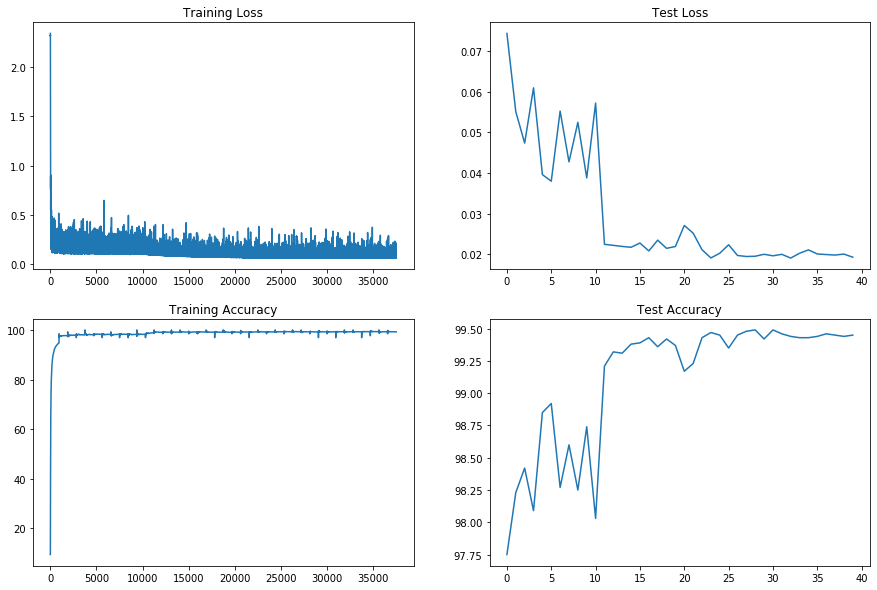

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**CHECK MISSCLASSIFIED SAMPLES**

In [0]:
def test_misclassified(model, device, test_loader, nimage = 25):
    model.eval()
    images = []
    preds = []
    actual = []
    #test_loss = 0
    #correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True).view_as(target)  # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()
            for a,b,c in zip(data, target, pred):
              if b!=c:
                a = a.cpu().numpy()
                b = b.cpu().numpy()
                c = c.cpu().numpy()
                a = (a*0.3081)+0.1307
                images.append(a)
                preds.append(c)
                actual.append(b)
                count += 1
              if count == nimage:
                return images, actual, preds

In [0]:
def plot_images(images,actual,preds,nimage=25):
  fig = plt.figure(figsize=(15,18))
  for i in range(nimage):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(np.rollaxis(images[i],0,3).squeeze(),cmap='gray')
    #ax.axis('off')
    ax.set_title("Actual: " + str(actual[i]) + " predicted:  " + str(preds[i]))
  plt.show()


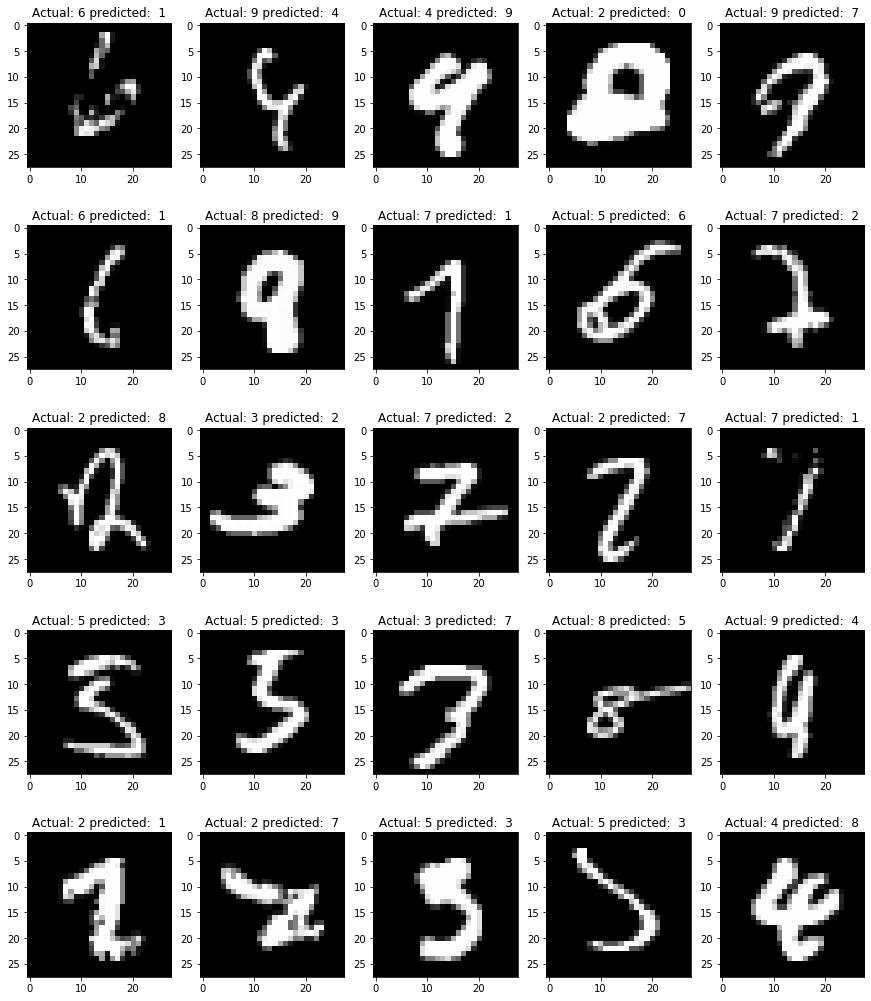

In [0]:
images, actuals, preds = test_misclassified(model,device,test_loader)
plot_images(images,actuals,preds)

In [0]:
test_acc

[97.75,
 98.23,
 98.42,
 98.09,
 98.85,
 98.92,
 98.27,
 98.6,
 98.25,
 98.74,
 98.03,
 99.21,
 99.32,
 99.31,
 99.38,
 99.39,
 99.43,
 99.36,
 99.42,
 99.37,
 99.17,
 99.23,
 99.43,
 99.47,
 99.45,
 99.35,
 99.45,
 99.48,
 99.49,
 99.42,
 99.49,
 99.46,
 99.44,
 99.43,
 99.43,
 99.44,
 99.46,
 99.45,
 99.44,
 99.45]

In [0]:
test_losses

[0.07442633078098297,
 0.05513506917953491,
 0.04737527358531952,
 0.06100715911388397,
 0.03960422608852387,
 0.037979753065109256,
 0.05527357864379883,
 0.04274931225776672,
 0.052501496171951295,
 0.03878770313262939,
 0.057239402222633365,
 0.022408894395828247,
 0.022152929592132567,
 0.021890758180618287,
 0.021677002477645875,
 0.02272734432220459,
 0.020780073952674866,
 0.02343551971912384,
 0.021418439769744873,
 0.021872527074813842,
 0.027058540081977844,
 0.025168478274345398,
 0.021072355699539184,
 0.01904959318637848,
 0.020206390476226806,
 0.02229899163246155,
 0.019660679769515993,
 0.01940583579540253,
 0.019466518568992616,
 0.019952217650413513,
 0.01957786250114441,
 0.019943429136276246,
 0.019019987750053407,
 0.020205087018013,
 0.02103769271373749,
 0.020029048752784728,
 0.019886729407310486,
 0.019761698746681215,
 0.020002126717567445,
 0.019231430888175964]